This is a naive implementation of Simplicial Map Neural Network (SMNN) to help its understanding and let the users experiment with it. Our intent is not to show its performance, so it is not set to high-precision results, but to provide insight into how it performs.

In [ ]:
!pip install networkx==2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [ ]:
from scipy.spatial import Delaunay
from scipy.spatial import distance_matrix
from sklearn import datasets
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tensorflow as tf

# Auxiliary functions

In [ ]:
def Sort_Tuple(tup):
  """
  Input:  tup= a list of tuples (j,xij) where j is the index of the point uj in U
  and xij is the barycentric coordinate associated to uj of a point x in R^n
  Output: the list tup sorted by the influences of the points of U on the point x
  (i.e., sorted by xij). This function will be used to explain the result obtained
  by the SMNN
  """
  lst = len(tup)
  for i in range(lst):

        for j in range(lst-i-1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp

  return tup

def representative_Us(V,epsilon=0.1):
    """
    Input:  V=set of points in R^n,
            epsilon=real number>0
    Output: V[dom] =  Subset of V with  representativeness factor epsilon
                      (i.e, each point of V is at distance less or equal to epsilon
                      to a point of V[dom])
    """
    ady = distance_matrix(V,V)
    g = nx.from_numpy_matrix(ady<epsilon)
    dom = np.array(list(nx.dominating_set(g)))

    return V[dom]

def hyperplane(ps):
    """
    Input: ps=set of n-1 points in R^n
    Output: coeffs= coefficients and c=independent term of the equation of the
    hyperplane determined by the points ps
    """
    b=np.array([1]*len(ps))
    coeffs = np.linalg.solve(ps,b)
    c=-np.sum(np.multiply(ps[0],coeffs))

    return coeffs, c

center_function = lambda X: X - X.mean() #Move the set X so that its center of mass is the coordinate origin

def boundary(tri):
    """
    Input:  tri=a Delaunay triangulation
    Output: the boundary of tri. That is,
            np.stack(n_simplices)=a set of n-simplices and
            np.stack(n_1_simplices)=a set of (n-1)-simplices
            such that each (n-1)-simplex is shared by exactly one n-simplex of tri.
    """
    maximal_simplices = tri.simplices
    neighbors = tri.neighbors
    n_1_simplices = list()
    n_simplices = list()
    for i in range(len(maximal_simplices)):
        neighbor = neighbors[i]
        if (-1) in neighbor:
            simplex = maximal_simplices[i]
            for j in range(len(simplex)):
              if neighbor[j]==-1:
                face = np.delete(simplex,j)
                n_1_simplices.append(face)
                n_simplices.append(simplex)

    return np.stack(n_simplices), np.stack(n_1_simplices)

def barycentric_respect_to_del(vs,tri,R=10,maximal_simplexes=[], boundary_tri=[]):
  """
  Input:  vs= set of points in R^n
          tri=a Delaunay triangulation in R^n
          R= radio of the hypersphere
          maximal_simplices=maximal simplices of tri (if we have precomputed it, we don't compute it again)
          boundary_tri=the output of boundary(tri) (if we have precomputed it, we don't compute it again)
  Output: np.stack(bss)=the set of xi(v) for each point v of vs,
          where xi_j(v) corresponds to the barycentric coordinates b(v) of v associated to vertex uj in the triangulation tri
          maximal_simplices=maximal simplices of tri
          boundary_tri=the output of boundary(tri)
  """
  n=len(vs)
  u_len = len(tri.points)
  l_simplex = len(tri.simplices[0])
  bss = list()
  if len(maximal_simplexes)==0:
      maximal_simplexes, boundary_tri=boundary(tri)
      print("Boundary already computed")
  counter=0
  for v in vs:
    print(counter," of ",n)
    counter+=1
    i= tri.find_simplex(v)
    if i!=-1:
        simplex = tri.simplices[i]
        b=tri.transform[i,:len(simplex)-1].dot(np.transpose([v] - tri.transform[i,len(simplex)-1]))
        b= np.c_[np.transpose(b), 1 - b.sum(axis=0)][0]
        u = np.array([0.0]*u_len)
        for j in range(len(simplex)):
            u[simplex[j]]=b[j]
        bss.append(u)
    else:
        print("Found a point v outside the triangulation")
        P=R*v/np.linalg.norm(v)
        for j in range(len(boundary_tri)):
            sigma = boundary_tri[j] #Ex. sigma=[2, 54,13]
            max_simplex = maximal_simplexes[j]
            p0=np.setdiff1d(max_simplex,sigma) #p0=vertex not in sigma but in the maximal simplex containing sigma
            p0=tri.points[p0][0] #coordinates
            points = tri.points[sigma] #coordinates
            coeffs_hyp, c = hyperplane(points)
            subst_p0_hyp=np.sum(np.multiply(p0,coeffs_hyp))+c
            subst_v_hyp=np.sum(np.multiply(v,coeffs_hyp))+c
            if (subst_p0_hyp * subst_v_hyp) < 0:
                ps = np.concatenate((tri.points[sigma],[P]))
                tri2 = Delaunay(ps)
                b=tri2.transform[0,:l_simplex-1].dot(np.transpose([v] - tri2.transform[0,l_simplex-1]))
                b= np.c_[np.transpose(b), 1 - b.sum(axis=0)][0]
                cond1 = all(b>=0)
                if cond1:
                    break
        print("Found a face mu in the boundary of tri")
        u = np.array([0.0]*u_len)
        for j in range(len(sigma)):
            u[sigma[j]]=b[j]  ##Ex. sigma=[2, 54,13], sigma[0]=2,  u[2]=b[0]
        bss.append(u)
        print("Barycentric coordinates  of v computed.")

  return np.stack(bss), maximal_simplexes, boundary_tri


def SMNN(V,y,epochs,epsilon_param=10):

    """
    Train a SMNN on a dataset V with y labels during a certain number of epochs
    and computes a representative dataset with epsilon equals to R/epsilon_param.


     Input:  V= set of points in R^n
             y= set of labels where i-th label in y corresponds to i-th vertex in V
             epoch=number of epochs to train the SMNN
             epsilon_param =>  used to compute a dataset Us

     Output:   bis= the set of points xi(v) for each point v of V
               y_hot= one_hot vectors associated to labels y
               Us= representative dataset with representativeness factor epsilon = R/epsilon_param
               tri=Delaunay triangulation with vertex set Us
               model= tf.keras.Sequential()
               history=model.fit(...)
               m=Us.mean()
               R= 0.5 + the maximum distance from V.mean() to any point of V used to compute epsilon
               maximal_simplices=maximal simplices of tri
               boundary_tri=the output of boundary(tri)
    """
    n_features = np.shape(V)[1]
    R=np.max(distance_matrix([[0]*n_features],center_function(V))[0])+0.5
    eps=R/epsilon_param
    Us = representative_Us(V,eps)
    print("Using representative dataset of size",len(Us))
    m=Us.mean()
    print("Centering Us")
    Us=Us-m
    print("Centering V with respect to the center of mass of Us")
    V=V-m

    #%%
    tri = Delaunay(Us)
    print("Delaunay triangulation already computed")

    #%% labels update
    n_classes = len(set(y))
    y_hot=tf.one_hot(y,depth=n_classes)
    y_hot=np.array(y_hot)

    #%%
    bis, maximal_simplexes, boundary_tri=np.array(barycentric_respect_to_del(V,tri,R))
    print("Barycentric coordinates already computed.")
    input_dim = np.shape(bis)[1]

    #%%
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(n_classes, activation="softmax",use_bias=False, input_shape=(input_dim,)))
    loss = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

    model.compile(optimizer="sgd",loss="categorical_crossentropy",metrics=["accuracy"])
    print("Training neural network...")
    history = model.fit(bis,y_hot,epochs=epochs, verbose = True)

    return (bis, y_hot, Us, tri, model, history,m, R,maximal_simplexes, boundary_tri)

# Example

This is a step by step example. The final code to be published have all the routines implemented as a python package so that experimentation with Simplicial Map Neural Networks (SMNNs) can be easily done. Let us consider a two-dimensional (for visualization purposes) dataset and let us train and apply a SMNN:

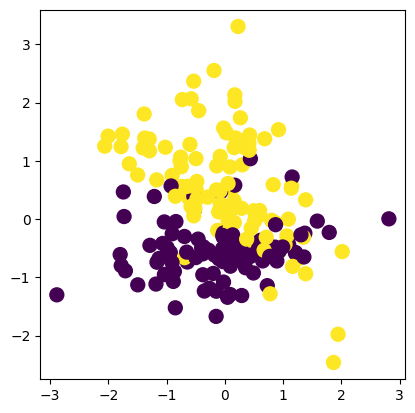

In [ ]:
n_features = 2 # two dimensions
size = 200 # number of points
n_classes = 2 # binary classification
X,y=datasets.make_classification(size, n_features=n_features, n_redundant=0,n_classes=n_classes,n_informative=2,class_sep=0.5)
# We split the dataset in training a test data.
V_train,V_test, y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.25)
# Let us plot the dataset
plt.scatter(V_train[:,0],V_train[:,1],c=y_train,s=100)
plt.scatter(V_test[:,0],V_test[:,1],c=y_test,s=100)
plt.gca().set_aspect('equal')

We have to choose a subset of the training data called the support set of points. It is going to be a representative subset with ɛ parameter depending on the radius of the hypersphere R. In this case, we will take \frac{R}{10}.

We can now train a SMNN on the given dataset

In [ ]:
# The following two parameters can be tuned for a better performance.
epsilon_param=10
epochs=500

bis, y_hot, Us, tri, model, history, m ,R,maximal_simplexes, boundary_tri= SMNN(V_train,y_train,epochs=epochs,epsilon_param=epsilon_param)
model.evaluate(bis, y_hot)

Using representative dataset of size 42
Centering Us
Centering V with respect to the center of mass of Us
Delaunay triangulation already computed
Boundary already computed
0  of  150
1  of  150
2  of  150
3  of  150
4  of  150
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
5  of  150
6  of  150
7  of  150
8  of  150
9  of  150
10  of  150
11  of  150
12  of  150
13  of  150
14  of  150
15  of  150
16  of  150
17  of  150
18  of  150
19  of  150
20  of  150
21  of  150
22  of  150
23  of  150
24  of  150
25  of  150
26  of  150
27  of  150
28  of  150
29  of  150
30  of  150
31  of  150
32  of  150
33  of  150
34  of  150
35  of  150
36  of  150
37  of  150
38  of  150
39  of  150
40  of  150
41  of  150
42  of  150
43  of  150
44  of  150
45  of  150
46  of  150
47  of  150
48  of  150
49  of  150
50  of  150
51  of  150
52  of  150
Found a point v outside the triangulation
Found a face mu in the boundary of tri


<ipython-input-8-efeb9bd99891>:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bis, maximal_simplexes, boundary_tri=np.array(barycentric_respect_to_del(V,tri,R))


Training neural network...
Epoch 1/500
5/5 [==============================] - 1s 5ms/step - loss: 0.7316 - accuracy: 0.4133
Epoch 2/500
5/5 [==============================] - 0s 3ms/step - loss: 0.7311 - accuracy: 0.4200
Epoch 3/500
5/5 [==============================] - 0s 3ms/step - loss: 0.7306 - accuracy: 0.4200
Epoch 4/500
5/5 [==============================] - 0s 3ms/step - loss: 0.7301 - accuracy: 0.4200
Epoch 5/500
5/5 [==============================] - 0s 3ms/step - loss: 0.7297 - accuracy: 0.4200
Epoch 6/500
5/5 [==============================] - 0s 3ms/step - loss: 0.7292 - accuracy: 0.4267
Epoch 7/500
5/5 [==============================] - 0s 3ms/step - loss: 0.7287 - accuracy: 0.4267
Epoch 8/500
5/5 [==============================] - 0s 3ms/step - loss: 0.7282 - accuracy: 0.4333
Epoch 9/500
5/5 [==============================] - 0s 3ms/step - loss: 0.7277 - accuracy: 0.4333
Epoch 10/500
5/5 [==============================] - 0s 3ms/step - loss: 0.7273 - accuracy: 0.4333
Ep

[0.5667469501495361, 0.8133333325386047]

The performance on the trainin data can be evaluated in the following way:

In [ ]:
model.evaluate(bis, y_hot)

5/5 [==============================] - 0s 2ms/step - loss: 0.5667 - accuracy: 0.8133


[0.5667469501495361, 0.8133333325386047]

If we want to evaluate the performance on the test set, we need to compute the barycentric coordinates of the test set respect to the triangulation.

In [ ]:
bis_test,maximal_simplexes, boundary_tri=barycentric_respect_to_del(V_test-m,tri,R=R,maximal_simplexes=maximal_simplexes, boundary_tri=boundary_tri)
y_hot_test=tf.one_hot(y_test,depth=n_classes)
y_hot_test=np.array(y_hot_test)

0  of  50
1  of  50
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
2  of  50
3  of  50
4  of  50
5  of  50
6  of  50
7  of  50
8  of  50
9  of  50
10  of  50
11  of  50
12  of  50
13  of  50
14  of  50
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
15  of  50
16  of  50
17  of  50
18  of  50
19  of  50
20  of  50
21  of  50
22  of  50
23  of  50
24  of  50
25  of  50
26  of  50
27  of  50
28  of  50
29  of  50
30  of  50
31  of  50
32  of  50
33  of  50
34  of  50
35  of  50
36  of  50
37  of  50
38  of  50
39  of  50
40  of  50
41  of  50
42  of  50
43  of  50
44  of  50
45  of  50
46  of  50
47  of  50
48  of  50
49  of  50


In [ ]:
model.evaluate(bis_test,y_hot_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.5719 - accuracy: 0.8200


[0.5719332098960876, 0.8199999928474426]

Let us plot the given dataset with the support points, the triangulation and the associated hypersphere.

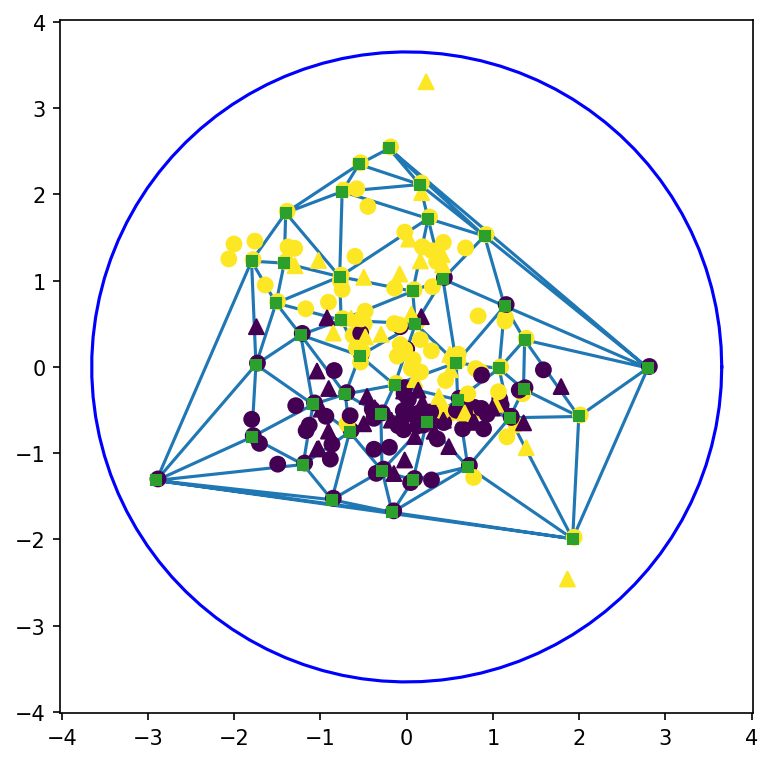

In [ ]:
plt.figure(figsize=(8, 6), dpi=150)
plt.triplot(Us[:,0], Us[:,1], tri.simplices)

angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
xs = R*np.cos(angles)
ys = R*np.sin(angles)
plt.plot(xs, ys, color = 'blue')
plt.plot(Us[:,0],Us[:,1],'s',markersize=5)
plt.scatter(V_train[:,0],V_train[:,1],c=y_train,s=50)
plt.scatter(V_test[:,0],V_test[:,1],c=y_test,s=50,marker="^")
plt.gca().set_aspect('equal')

## Explainability

With the following function, we can print the contribution of each influence point to the test data to be explained. Some information is displayed such as the prediction and real class, \phi weights for the influence points and their prediction value, as well as their contribution for the test data to belong for each class.

In [ ]:
def explain(model,index,V_test,bis_test,V_train,bis,n_classes,y_test=[]):
    weights=model.weights[0]
    print("The following point of the test: ",V_test[index])
    print("is predicted to be:",model.predict(np.array([bis_test[index]])))
    if len(y_test)!=0:
        print("and its true class is:",y_test[index],"\n")
    print("%---------------------------------------%")
    # Barycentric coordinares respecto the elements of the simplex it belongs to
    influence_points=Sort_Tuple([(j,bis_test[index][j]) for j in range(len(bis_test[index])) if bis_test[index][j]!=0])
    contributions = list()
    for (i,b) in influence_points:
        print("Index of the point in U is:",i)
        print("Influence ratio based on barycentric coordinates:",b)
        phi=np.array(weights[i])
        print("and its phi value:",phi)
        prediction=model.predict(np.array([bis[i]]))[0]
        print("And its prediction value is:",prediction)
        for j in range(n_classes):
            contribution=(i,j,b*phi[j])
            contributions.append(contribution)
            print("Contribution to the",j,"class:",contribution[2])
        print("----------------------------------------------------------------")
    n_inf = len(influence_points)
    r = np.arange(n_inf)
    width = 1/n_inf
    count=0
    for j in range(n_classes):
        cont_j = [cont for (i,label,cont) in contributions if label==j]
        plt.bar(r+count*width, cont_j,label="Class:"+str(j),width=width,align='center')
        count+=1
    plt.xlabel("Influence point indexes in Us")
    plt.ylabel("Contribution")
    plt.title("Contribution of each influence point for each class")
    plt.xticks(r,[str(i[0]) for i in influence_points])
    plt.legend()

The following point of the test:  [-0.90476291 -0.25094432]
1/1 [==============================] - 0s 98ms/step
is predicted to be: [[0.6298901 0.3701099]]
and its true class is: 0 

%---------------------------------------%
Index of the point in U is: 23
Influence ratio based on barycentric coordinates: 0.1338092958652399
and its phi value: [-0.1757655  -0.12109635]
1/1 [==============================] - 0s 28ms/step
And its prediction value is: [0.69547075 0.30452925]
Contribution to the 0 class: -0.023519057721833225
Contribution to the 1 class: -0.016203817359154663
----------------------------------------------------------------
Index of the point in U is: 4
Influence ratio based on barycentric coordinates: 0.3762809532990242
and its phi value: [ 0.25300545 -0.45753488]
1/1 [==============================] - 0s 27ms/step
And its prediction value is: [0.4670559  0.53294414]
Contribution to the 0 class: 0.09520113003576441
Contribution to the 1 class: -0.17216166060550617
----------

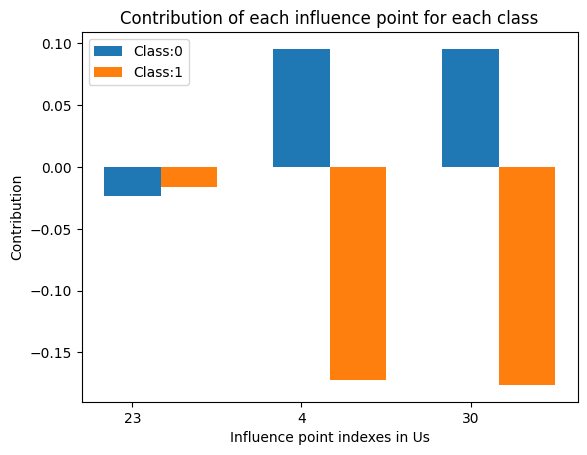

In [ ]:
test_index = 0 # index of the test data to be explained
explain(model,test_index,V_test,bis_test,V_train,bis,n_classes,y_test)

# Iris example

In [ ]:
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target
V_train,V_test, y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.25)

In [ ]:
epsilon_param=100
epochs=1000

bis, y_hot, Us, tri, model, history, m ,R,maximal_simplexes, boundary_tri= SMNN(V_train,y_train,epochs=epochs,epsilon_param=epsilon_param)


Using representative dataset of size 111
Centering Us
Centering V with respect to the center of mass of Us
Delaunay triangulation already computed
Boundary already computed
0  of  112
1  of  112
2  of  112
3  of  112
4  of  112
5  of  112
6  of  112
7  of  112
8  of  112
9  of  112
10  of  112
11  of  112
12  of  112
13  of  112
14  of  112
15  of  112
16  of  112
17  of  112
18  of  112
19  of  112
20  of  112
21  of  112
22  of  112
23  of  112
24  of  112
25  of  112
26  of  112
27  of  112
28  of  112
29  of  112
30  of  112
31  of  112
32  of  112
33  of  112
34  of  112
35  of  112
36  of  112
37  of  112
38  of  112
39  of  112
40  of  112
41  of  112
42  of  112
43  of  112
44  of  112
45  of  112
46  of  112
47  of  112
48  of  112
49  of  112
50  of  112
51  of  112
52  of  112
53  of  112
54  of  112
55  of  112
56  of  112
57  of  112
58  of  112
59  of  112
60  of  112
61  of  112
62  of  112
63  of  112
64  of  112
65  of  112
66  of  112
67  of  112
68  of  112
69  of  1

<ipython-input-8-efeb9bd99891>:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bis, maximal_simplexes, boundary_tri=np.array(barycentric_respect_to_del(V,tri,R))


Training neural network...
Epoch 1/1000
4/4 [==============================] - 0s 6ms/step - loss: 1.1041 - accuracy: 0.3393
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 1.1039 - accuracy: 0.3393
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.1036 - accuracy: 0.3393
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.1034 - accuracy: 0.3393
Epoch 5/1000
4/4 [==============================] - 0s 3ms/step - loss: 1.1032 - accuracy: 0.3393
Epoch 6/1000
4/4 [==============================] - 0s 3ms/step - loss: 1.1029 - accuracy: 0.3393
Epoch 7/1000
4/4 [==============================] - 0s 3ms/step - loss: 1.1027 - accuracy: 0.3393
Epoch 8/1000
4/4 [==============================] - 0s 3ms/step - loss: 1.1024 - accuracy: 0.3393
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.1022 - accuracy: 0.3393
Epoch 10/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.1019 - accuracy:

In [ ]:
bis_test,maximal_simplexes, boundary_tri=barycentric_respect_to_del(V_test-m,tri,R=R,maximal_simplexes=maximal_simplexes, boundary_tri=boundary_tri)
y_hot_test=tf.one_hot(y_test,depth=3)
y_hot_test=np.array(y_hot_test)
model.evaluate(bis_test,y_hot_test)

0  of  38
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
1  of  38
2  of  38
3  of  38
4  of  38
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
5  of  38
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
6  of  38
7  of  38
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
8  of  38
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
9  of  38
10  of  38
11  of  38
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
12  of  38
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
13  of  38
Found a p

[0.9773222208023071, 0.7631579041481018]

The following point of the test:  [6.  2.2 4.  1. ]
1/1 [==============================] - 0s 77ms/step
is predicted to be: [[0.3157947  0.37313077 0.31107453]]
and its true class is: 1 

%---------------------------------------%
Index of the point in U is: 41
Influence ratio based on barycentric coordinates: 0.11882992411253401
and its phi value: [-0.20637555  0.17543839 -0.01463535]
1/1 [==============================] - 0s 39ms/step
And its prediction value is: [0.27201298 0.39848253 0.32950446]
Contribution to the 0 class: -0.02452359144474194
Contribution to the 1 class: 0.020847330472933055
----------------------------------------------------------------
Index of the point in U is: 7
Influence ratio based on barycentric coordinates: 0.14542931599932274
and its phi value: [ 0.01316724  0.0200861  -0.24013528]
1/1 [==============================] - 0s 72ms/step
And its prediction value is: [0.35930178 0.36179635 0.27890188]
Contribution to the 0 class: 0.0019149032086580478
Contrib

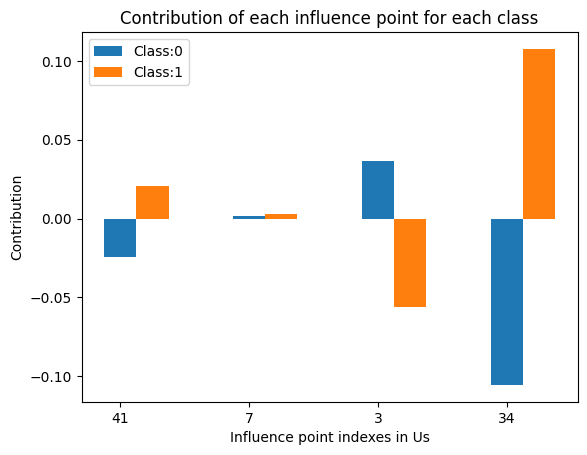

In [ ]:
explain(model,test_index,V_test,bis_test,V_train,bis,n_classes,y_test)

# Spiral dataset

This is a binary classification problem composed of two spirals.

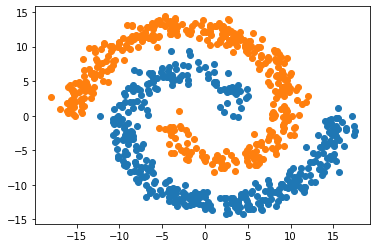

In [ ]:
N = 400
theta = np.sqrt(np.random.rand(N))*2*np.pi # np.linspace(0,2*pi,100)

r_a = 2*theta + np.pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - np.pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)

plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])
plt.show()

V_train,V_test, y_train, y_test = model_selection.train_test_split(res[:,0:2],res[:,2],test_size = 0.25)

In [ ]:
epsilon_param=5
epochs=200

bis, y_hot, Us, tri, model, history, m ,R,maximal_simplexes, boundary_tri= SMNN(V_train,y_train,epochs=epochs,epsilon_param=epsilon_param)

Using representative dataset of size 29
Centering Us
Centering V with respect to the center of mass of Us
Delaunay triangulation already computed
Boundary already computed
0  of  600
1  of  600
2  of  600
3  of  600
4  of  600
5  of  600
6  of  600
7  of  600
8  of  600
9  of  600
10  of  600
11  of  600
12  of  600
13  of  600
14  of  600
15  of  600
16  of  600
17  of  600
18  of  600
19  of  600
20  of  600
21  of  600
22  of  600
23  of  600
24  of  600
25  of  600
26  of  600
27  of  600
28  of  600
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
29  of  600
30  of  600
31  of  600
32  of  600
33  of  600
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
34  of  600
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
35  of  600
36  of  600
37  of  600
Found a point v out

<ipython-input-3-ebf0e692bc5e>:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bis, maximal_simplexes, boundary_tri=np.array(barycentric_respect_to_del(V,tri,R))


Barycentric coordinates already computed.
Training neural network...
Epoch 1/200
19/19 [==============================] - 0s 2ms/step - loss: 0.6391 - accuracy: 0.7133
Epoch 2/200
19/19 [==============================] - 0s 2ms/step - loss: 0.6373 - accuracy: 0.7167
Epoch 3/200
19/19 [==============================] - 0s 2ms/step - loss: 0.6354 - accuracy: 0.7183
Epoch 4/200
19/19 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.7233
Epoch 5/200
19/19 [==============================] - 0s 2ms/step - loss: 0.6318 - accuracy: 0.7317
Epoch 6/200
19/19 [==============================] - 0s 2ms/step - loss: 0.6299 - accuracy: 0.7367
Epoch 7/200
19/19 [==============================] - 0s 2ms/step - loss: 0.6281 - accuracy: 0.7383
Epoch 8/200
19/19 [==============================] - 0s 2ms/step - loss: 0.6263 - accuracy: 0.7400
Epoch 9/200
19/19 [==============================] - 0s 2ms/step - loss: 0.6245 - accuracy: 0.7417
Epoch 10/200
19/19 [====================

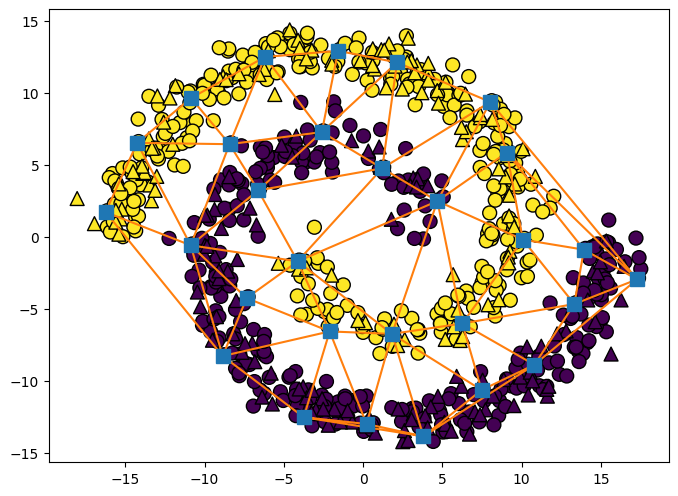

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(Us[:,0],Us[:,1],"s",markersize=10)
plt.scatter(V_train[:,0],V_train[:,1],c=y_train,s=100,edgecolors='black')
plt.scatter(V_test[:,0],V_test[:,1],c=y_test,s=100,marker="^",edgecolors='black')
plt.triplot(Us[:,0], Us[:,1], tri.simplices)

In [ ]:
bis_test,maximal_simplexes, boundary_tri=barycentric_respect_to_del(V_test-m,tri,R=R,maximal_simplexes=maximal_simplexes, boundary_tri=boundary_tri)
y_hot_test=tf.one_hot(y_test,depth=2)
y_hot_test=np.array(y_hot_test)
model.evaluate(bis_test,y_hot_test)

0  of  200
1  of  200
2  of  200
3  of  200
4  of  200
5  of  200
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
6  of  200
7  of  200
8  of  200
9  of  200
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
10  of  200
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
11  of  200
12  of  200
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
13  of  200
14  of  200
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
15  of  200
16  of  200
17  of  200
18  of  200
Found a point v outside the triangulation
Found a face mu in the boundary of tri
Barycentric coordinates  of v computed.
19  of  200
20  of  200
21  of  200
22  of  200
23  of  

[0.38612526655197144, 0.9800000190734863]